# Data Exploration Project - Pumps

## Business Understanding

Daten über verschiedene Brunnen in einem afrikanischen Land.

**Können wir vorhersagen welche Brunnen defekt, wartungsbedürftig oder voll funktional sind?**

## Data Understanding

In [204]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [205]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from category_encoders import TargetEncoder, BinaryEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

Einlesen der Trainings- und Testdaten.

In [206]:
df_pump_train = pd.read_csv('pump_train.csv')
df_pump_test = pd.read_csv('pump_test.csv')

### Data Dictionary
| Variable | Beschreibung |
| -------- | ------------ |
| amount_tsh | Total static head (amount water available to waterpoint) |
| date_recorded | The date the row was entered |
| funder | Who funded the well |
| gps_height | Altitude of the well |
| installer | Organization that installed the well |
| longitude | GPS coordinate |
| latitude | GPS coordinate |
| wpt_name | Name of the waterpoint if there is one |
| num_private | ? |
| basin | Geographic water basin |
| subvillage | Geographic location |
| region | Geographic location |
| region_code | Geographic location (coded) |
| district_code | Geographic location (coded) |
| lga | Geographic location |
| ward | Geographic location |
| population | Population around the well |
| public_meeting | True/False |
| recorded_by | Group entering this row of data 
| scheme_management | Who operates the waterpoint |
| scheme_name | Who operates the waterpoint |
| permit | If the waterpoint is permitted |
| construction_year | Year the waterpoint was constructed 
| extraction_type | The kind of extraction the waterpoint uses 
| extraction_type_group | The kind of extraction the waterpoint uses |
| extraction_type_class | The kind of extraction the waterpoint uses 
| management | How the waterpoint is managed |
| management_group | How the waterpoint is managed |
| payment | What the water costs |
| payment_type | What the water costs |
| water_quality | The quality of the water |
| quality_group | The quality of the water |
| quantity | The quantity of water |
| quantity_group | The quantity of water |
| source | The source of the water |
| source_type | The source of the water |
| source_class | The source of the water |
| waterpoint_type | The kind of waterpoint |
| waterpoint_type_group | The kind of waterpoint |
| status_group | functional or non-functional or functional needs repair |

### Data Analysis

## Data Preparation

## Pipeline

[Categoric Encoder Package ->](https://contrib.scikit-learn.org/category_encoders/index.html)

In [207]:
class YesNoEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, add_column = True):
        self.add_column = add_column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.add_column:
            has_name = np.where(X['wpt_name']!= 'none', 1, 0)
            Xcopy = X
            Xcopy['wpt_name'] = has_name
        return Xcopy

In [208]:
class MyImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value="other"):
        self.fill_value = fill_value
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array([self.fill_value if str(x)==str(np.nan) else x for x in X]).reshape(-1,1)

In [209]:
scheme_pipeline = Pipeline([
('imputer', MyImputer(fill_value="other")),
('one_hot', OneHotEncoder())
])

In [210]:
scheme_pipeline_lbl = Pipeline([
    ('imputer', MyImputer(fill_value="other")),
    ('ord_enc', OrdinalEncoder()),
    ('min_max', MinMaxScaler())
])

In [211]:
class YearAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        date_column = pd.Series(X)
        return np.array(pd.DatetimeIndex(date_column).year).reshape(-1,1)
        

In [212]:
year_pipeline = Pipeline([
    ("add_year", YearAdder()),
    # ("ord_enc", OrdinalEncoder()),
    ("scale", MinMaxScaler())
])

In [213]:
class AmountPerCapitaAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        date_column = pd.Series(X)
        return np.array(pd.DatetimeIndex(date_column).year).reshape(-1,1)

In [214]:
age_pipeline = Pipeline([
    ("imp_age", SimpleImputer(strategy="median")),
    ("scale", MinMaxScaler())
])

In [215]:
col_imp = Pipeline([
    ('simp_inputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('target_enc', TargetEncoder()),
    ('min_max', MinMaxScaler())
])

In [216]:
target_enc_pipe = Pipeline([
    ('target_enc', TargetEncoder()),
    ('min_max', MinMaxScaler())
])

In [217]:
ord_enc_pipe = Pipeline([
    ('ord_enc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('min_max', MinMaxScaler())
])

In [218]:
df_train = df_pump_train.copy()

# add new target variables

df_train["t_functional"] = df_train["status_group"].apply(lambda x: 0 if x=="non functional" else 1)
df_train["t_needs_rep"] = df_train["status_group"].apply(lambda x: 1 if x=="functional needs repair" else 0)

# drop outliers
df_train = df_train.drop(df_train[df_train.longitude == 0].index)

# add some new features manually
df_train["amount_per_capita"] = df_train.apply(lambda x: x["amount_tsh"]/x["population"] if x["population"] != 0 else 0, axis=1)
import datetime
df_train["age"]=df_train['date_recorded'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))-df_train["construction_year"].apply(lambda x: datetime.datetime.strptime(str(x),'%Y') if x!=0 else datetime.datetime.now())
df_train["age"].loc[df_train["construction_year"]!=0]=df_train["age"].loc[df_train["construction_year"]!=0].apply(lambda x: x.days)
df_train["age"].loc[df_train["construction_year"]==0]=np.nan

# transform dtypes manually
df_train["district_code"] = df_train["district_code"].astype("category")
df_train["region_code"] = df_train["region_code"].astype("category")

y_train = df_train.loc[:,'status_group']
le = LabelEncoder()
y_train = le.fit_transform(y_train)

y_train_f = df_train["t_functional"]
y_train_r = df_train["t_needs_rep"]

col_trans = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['oh_enc', OneHotEncoder(handle_unknown='ignore'), ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class']],
    ['bin_enc', BinaryEncoder(), ['region', 'region_code', 'district_code']], # warum alle 3 ?
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"]
], remainder='drop')

col_trans_lbl = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['ord_enc', ord_enc_pipe, ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class', 'region', 'region_code', 'district_code']],
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline_lbl, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"]
], remainder='drop')

col_trans_w_age = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['oh_enc', OneHotEncoder(handle_unknown='ignore'), ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class']],
    ['bin_enc', BinaryEncoder(), ['region', 'region_code', 'district_code']], # warum alle 3 ?
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"],
    ["age", age_pipeline, ["age"]]
], remainder='drop')

col_trans_lbl_w_age = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['ord_enc', ord_enc_pipe, ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class', 'region', 'region_code', 'district_code']],
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline_lbl, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"],
    ["age", age_pipeline, ["age"]]
], remainder='drop')

/var/folders/m1/lfnpxhr54w36gr2xljxbctrh0000gn/T/ipykernel_53096/4104927532.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["age"].loc[df_train["construction_year"]!=0]=df_train["age"].loc[df_train["construction_year"]!=0].apply(lambda x: x.days)
/var/folders/m1/lfnpxhr54w36gr2xljxbctrh0000gn/T/ipykernel_53096/4104927532.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["age"].loc[df_train["construction_year"]==0]=np.nan


### Undersampling

https://imbalanced-learn.org/stable/under_sampling.html

Für die unterschiedlichen Ausprägungen der Target Variable `status_group` besteht, wie in der Data Analysis bereits festgestellt, ein Ungleichgewicht. Datenpunkte für die Gruppe 'functional needs repair' machen nur einen kleinen Teil der Gesamtheit aus. Dieses Ungeleichgewicht kann das Training unserer Modelle beeinflussen, da sich diese beim Training hauptsächlich auf die 'Majority Class' konzentriert. 

Möglichkeiten mit Ungleichgewicht umzugehen:
- Oversampling
- **Undersampling**

Wir entscheiden uns für Undersampling, da trotz der Einschränkung der Größe des Datensamples, noch eine viele Datenpunkte zur Verfügung stehen.

In [219]:
from imblearn.under_sampling import RandomUnderSampler

# sort data according to repair status
df_train_1 = df_train[df_train["t_needs_rep"] == 1] 
df_train_0 = df_train[df_train["t_needs_rep"] == 0]

num_r = len(df_train_1)
print(f"{num_r} pumps need repairs, therefore we need the same amount of pumps that don't need repairs")


rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(df_train, y_train_r)
print(X_resampled["t_needs_rep"].value_counts())


3356 pumps need repairs, therefore we need the same amount of pumps that don't need repairs
0    3356
1    3356
Name: t_needs_rep, dtype: int64


Anwendung der ColumnTransformer auf unsere Testdaten.

In [220]:
X_train_r = col_trans.fit_transform(X=X_resampled, y=y_resampled)
X_train_r_lbl = col_trans_lbl_w_age.fit_transform(X=X_resampled, y=y_resampled)
y_train_r = y_resampled

### Preparation Test Data

Die Testdaten müssen mit der gleichen Vorgehensweise wie die Trainingsdaten transformiert (Achtung: nicht gefittet!) werden, um für die Kontrolle der Performance eingesetzt werden zu können. ColumnTransformer helfen bei der Übertragbarkeit des Data Preparation Prozesses.

In [221]:
df_test = df_pump_test.copy()

df_test["t_functional"] = df_test["status_group"].apply(lambda x: 0 if x=="non functional" else 1)
df_test["t_needs_rep"] = df_test["status_group"].apply(lambda x: 1 if x=="functional needs repair" else 0)

df_test = df_test.drop(df_test[df_test.longitude == 0].index)

df_test["amount_per_capita"] = df_test.apply(lambda x: x["amount_tsh"]/x["population"] if x["population"] != 0 else 0, axis=1)
df_test["age"]=df_test['date_recorded'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))-df_test["construction_year"].apply(lambda x: datetime.datetime.strptime(str(x),'%Y') if x!=0 else datetime.datetime.now())
df_test["age"].loc[df_test["construction_year"]!=0]=df_test["age"].loc[df_test["construction_year"]!=0].apply(lambda x: x.days)
df_test["age"].loc[df_test["construction_year"]==0]=np.nan

df_test["district_code"] = df_test["district_code"].astype("category")
df_test["region_code"] = df_test["region_code"].astype("category")

y_test = df_test.loc[:,'status_group']
y_test = le.transform(y_test)

y_test_f = df_test["t_functional"]
y_test_r = df_test["t_needs_rep"]

X_test = col_trans.transform(X=df_test)
X_test_lbl = col_trans_lbl_w_age.transform(X=df_test)

/var/folders/m1/lfnpxhr54w36gr2xljxbctrh0000gn/T/ipykernel_53096/535234467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["age"].loc[df_test["construction_year"]!=0]=df_test["age"].loc[df_test["construction_year"]!=0].apply(lambda x: x.days)
/var/folders/m1/lfnpxhr54w36gr2xljxbctrh0000gn/T/ipykernel_53096/535234467.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["age"].loc[df_test["construction_year"]==0]=np.nan


## Model Training

***Prognosemodell für Brunnen die repariert werden müssen***

In [222]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_roc_curve, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV


### Model Selection

Zuerst erfolgt das Training unterschiedlicher Modelle mit der Standard-Konfiguration, um eine Vorauswahl zu treffen.

In [223]:
df_results = pd.DataFrame(data=[], columns=["Model", "AUC Train", "AUC CV", "ACC CV"])

Es soll die AUC als Qualitätsmaß genutzt werden. Die Accuray ist jedoch auch von Interesse.

In [224]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

#### LogisticRegression

In [225]:
lr_cf = LogisticRegression(max_iter=1000, random_state=42)
lr_cf.fit(X_train_r, y_train_r)
y_pred = lr_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=lr_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [lr_cf, auc_train, auc_cv, acc_cv]

#### SVM

In [226]:
svm_cf = SVC(probability=True, random_state=42, kernel="rbf")
svm_cf.fit(X_train_r, y_train_r)
y_pred = svm_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=svm_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [svm_cf, auc_train, auc_cv, acc_cv]

#### KNN

In [227]:
knn_cf = KNeighborsClassifier()
knn_cf.fit(X_train_r, y_train_r)
y_pred = knn_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=knn_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [knn_cf, auc_train, auc_cv, acc_cv]

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

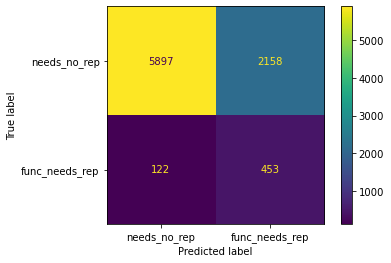

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      8055
           1       0.17      0.79      0.28       575

    accuracy                           0.74      8630
   macro avg       0.58      0.76      0.56      8630
weighted avg       0.93      0.74      0.80      8630



In [228]:
predictions = knn_cf.predict(X_test)
cm = confusion_matrix(y_test_r, predictions, labels=knn_cf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['needs_no_rep', 'func_needs_rep'])
disp.plot()
plt.show()

print(classification_report(y_test_r, predictions))

#### Decision Tree

In [229]:
dt_cf = DecisionTreeClassifier(random_state=42)
dt_cf.fit(X_train_r, y_train_r)
y_pred = dt_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=dt_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [dt_cf, auc_train, auc_cv, acc_cv]

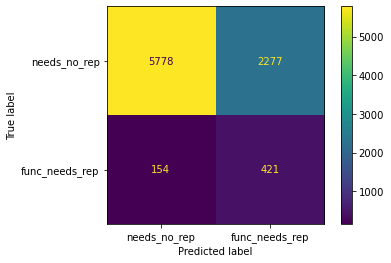

              precision    recall  f1-score   support

           0       0.97      0.72      0.83      8055
           1       0.16      0.73      0.26       575

    accuracy                           0.72      8630
   macro avg       0.57      0.72      0.54      8630
weighted avg       0.92      0.72      0.79      8630



In [230]:
predictions = dt_cf.predict(X_test)
cm = confusion_matrix(y_test_r, predictions, labels=dt_cf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['needs_no_rep', 'func_needs_rep'])
disp.plot()
plt.show()

print(classification_report(y_test_r, predictions))

#### Random Forest

In [231]:
rf_cf = RandomForestClassifier(random_state=42)
rf_cf.fit(X_train_r, y_train_r)
y_pred = rf_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=rf_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [str(rf_cf), auc_train, auc_cv, acc_cv]

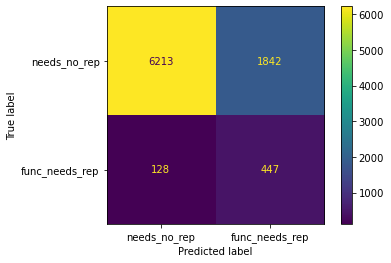

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      8055
           1       0.20      0.78      0.31       575

    accuracy                           0.77      8630
   macro avg       0.59      0.77      0.59      8630
weighted avg       0.93      0.77      0.83      8630



In [232]:
predictions = rf_cf.predict(X_test)
cm = confusion_matrix(y_test_r, predictions, labels=rf_cf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['needs_no_rep', 'func_needs_rep'])
disp.plot()
plt.show()

print(classification_report(y_test_r, predictions))

#### XGBoost

In [233]:
from xgboost import XGBClassifier

xgb_cf = XGBClassifier(use_label_encoder=False)
xgb_cf.fit(X_train_r, y_train_r)
y_pred = xgb_cf.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=xgb_cf, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_results.loc[len(df_results)] = [xgb_cf, auc_train, auc_cv, acc_cv]

[17:59:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:59:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:59:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

#### Model Score Comparison

In [234]:
df_results.to_csv("pm2_sel_results.csv")
df_results

,Model,AUC Train,AUC CV,ACC CV
0,"LogisticRegression(max_iter=1000, random_state...",0.923432,0.917923,0.824495
1,"SVC(probability=True, random_state=42)",0.937588,0.915691,0.826281
2,KNeighborsClassifier(),0.933883,0.843600,0.770112
3,DecisionTreeClassifier(random_state=42),1.000000,0.771158,0.771158
4,RandomForestClassifier(random_state=42),1.000000,0.894417,0.810490
5,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.990137,0.914013,0.812576


LogisticRegression, SVM, und XGBoost liefern alle vielversprechende Ergebnisse in einer ähnlichen Qualität.

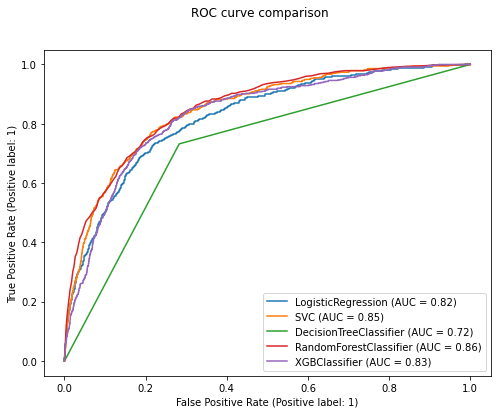

In [235]:
lr_disp = RocCurveDisplay.from_estimator(lr_cf, X_test, y_test_r)
svm_disp = RocCurveDisplay.from_estimator(svm_cf, X_test, y_test_r, ax=lr_disp.ax_)
dt_disp = RocCurveDisplay.from_estimator(dt_cf, X_test, y_test_r, ax=lr_disp.ax_)
rf_disp = RocCurveDisplay.from_estimator(rf_cf, X_test, y_test_r, ax=lr_disp.ax_)
xgb_disp = RocCurveDisplay.from_estimator(xgb_cf, X_test, y_test_r, ax=lr_disp.ax_)
lr_disp.figure_.suptitle("ROC curve comparison")
lr_disp.figure_.set_size_inches(8, 6)
plt.show()

Mit einer Evaluation auf den Testdaten wird klar, dass auch der RandomForest einbezogen werden sollte.

### Hyperparameter Tuning

Gewählte Modelle:
- RandomForest
- LogisticRegression
- SupportVectorMachine
- XGBoost

In [236]:
df_tuned = pd.DataFrame(data=[], columns=["Model", "AUC Train", "AUC CV", "ACC CV"])

#### Random Forest

Initiales Tuning mit RandomSearch, um den GridSearch Bereich einzuschränken.

In [238]:
model_params = {
    'n_estimators' : np.linspace(100, 1000, 5, dtype=int),
    'max_depth': np.linspace(5, 20, 4, dtype=int),
    'min_samples_split' : np.linspace(2, 30, 5, dtype=int),
    'min_samples_leaf' : np.linspace(1, 5, 3, dtype=int),
    'bootstrap' : [True, False]
}
rf_cf_tuned = RandomForestClassifier(random_state=42)
rs = RandomizedSearchCV(rf_cf_tuned, param_distributions=model_params, scoring="roc_auc", cv=5, verbose = 2)
rs.fit(X_train_r, y_train_r)
rs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=15, min_samples_leaf=3, min_samples_split=23, n_estimators=550; total time=   3.4s
[CV] END bootstrap=True, max_depth=15, min_samples_leaf=3, min_samples_split=23, n_estimators=550; total time=   2.9s
[CV] END bootstrap=True, max_depth=15, min_samples_leaf=3, min_samples_split=23, n_estimators=550; total time=   3.0s
[CV] END bootstrap=True, max_depth=15, min_samples_leaf=3, min_samples_split=23, n_estimators=550; total time=   2.9s
[CV] END bootstrap=True, max_depth=15, min_samples_leaf=3, min_samples_split=23, n_estimators=550; total time=   2.9s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=23, n_estimators=550; total time=   2.3s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=23, n_estimators=550; total time=   2.3s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=23, n_estimators=550; total time=   

{'n_estimators': 550,
 'min_samples_split': 23,
 'min_samples_leaf': 1,
 'max_depth': 15,
 'bootstrap': False}

In [241]:
param_grid = [{
    'n_estimators' : [250, 500, 750],
    'max_depth': [10, 15, 20],
    'min_samples_split' : [20, 25, 30],
    'min_samples_leaf' : [1, 2],
    'bootstrap' : [False]
}]
rf_cf_tuned = RandomForestClassifier(random_state=42)
gs = GridSearchCV(rf_cf_tuned, param_grid=param_grid, scoring="roc_auc", cv=5, verbose = 2, n_jobs=-1)
gs.fit(X_train_r, y_train_r)
gs.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=20, n_estimators=250; total time=   2.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=20, n_estimators=250; total time=   2.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=20, n_estimators=250; total time=   2.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=20, n_estimators=250; total time=   2.9s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=20, n_estimators=250; total time=   2.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=20, n_estimators=500; total time=   5.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=20, n_estimators=500; total time=   5.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=20, n_estimators=500; total

{'bootstrap': False,
 'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 30,
 'n_estimators': 750}

In [242]:
rf_cf_tuned = gs.best_estimator_
rf_cf_tuned.fit(X_train_r, y_train_r)
y_pred = rf_cf_tuned.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=rf_cf_tuned, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_tuned.loc[len(df_tuned)] = [str(rf_cf_tuned), auc_train, auc_cv, acc_cv]

#### Random Forest Lable Econding

Lable Encoding erzeugt wesentlich weniger Features. Wirkt sich das auf die Performance des Modells aus?

In [301]:
model_params = {
    'n_estimators' : np.linspace(100, 1000, 5, dtype=int),
    'max_depth': np.linspace(5, 20, 4, dtype=int),
    'min_samples_split' : np.linspace(2, 30, 5, dtype=int),
    'min_samples_leaf' : np.linspace(1, 5, 3, dtype=int),
    'bootstrap' : [True, False]
}
rf_cf_lbl = RandomForestClassifier(random_state=42)
rs = RandomizedSearchCV(rf_cf_lbl, param_distributions=model_params, scoring="roc_auc", cv=5, verbose = 2)
rs.fit(X_train_r_lbl, y_train_r)
rs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=1, min_samples_split=9, n_estimators=550; total time=   8.5s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=1, min_samples_split=9, n_estimators=550; total time=  11.6s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=1, min_samples_split=9, n_estimators=550; total time=  12.9s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=1, min_samples_split=9, n_estimators=550; total time=  11.8s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=1, min_samples_split=9, n_estimators=550; total time=  12.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=3, min_samples_split=16, n_estimators=325; total time=   5.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=3, min_samples_split=16, n_estimators=325; total time=   5.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=3, min_samples_split=16, n_estimators=325; total time=

{'n_estimators': 100,
 'min_samples_split': 23,
 'min_samples_leaf': 1,
 'max_depth': 10,
 'bootstrap': False}

In [302]:
rf_cf_lbl = rs.best_estimator_
rf_cf_lbl.fit(X_train_r_lbl, y_train_r)
y_pred = rf_cf_lbl.predict_proba(X_train_r_lbl)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=rf_cf_lbl, X=X_train_r_lbl, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

print(str(rf_cf_lbl), auc_train, auc_cv, acc_cv)

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_split=23,
                       random_state=42) 0.9541516377548047 0.9176549654201068 0.8262834391052352


#### Logistic Regression

In [248]:
model_params = {
    'penalty' : ['l1', 'l2'],
    'C': np.linspace(0.1, 2, 5, dtype=float),
    'solver' : ['liblinear', 'saga', 'lbfgs']
}
lr_cf_tuned = LogisticRegression(random_state=42)
rs = RandomizedSearchCV(lr_cf_tuned, param_distributions=model_params, scoring="roc_auc", cv=5, verbose = 2)
rs.fit(X_train_r, y_train_r)
rs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...................C=0.575, penalty=l1, solver=saga; total time=   0.8s
[CV] END ...................C=0.575, penalty=l1, solver=saga; total time=   0.4s
[CV] END ...................C=0.575, penalty=l1, solver=saga; total time=   0.2s
[CV] END ...................C=0.575, penalty=l1, solver=saga; total time=   0.4s
[CV] END ...................C=0.575, penalty=l1, solver=saga; total time=   0.4s
[CV] END ...............C=1.05, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=1.05, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=1.05, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1.05, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1.05, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, 

/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[CV] END ....................C=2.0, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ....................C=2.0, penalty=l2, solver=lbfgs; total time=   0.1s


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[CV] END ....................C=2.0, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ....................C=2.0, penalty=l2, solver=lbfgs; total time=   0.1s


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[CV] END ...................C=1.05, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ...................C=1.05, penalty=l2, solver=lbfgs; total time=   0.1s


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[CV] END ...................C=1.05, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ...................C=1.05, penalty=l2, solver=lbfgs; total time=   0.1s


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[CV] END ...................C=1.05, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=0.575, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.575, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.575, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.575, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.575, penalty=l1, solver=lbfgs; total time=   0.0s


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[CV] END ..................C=0.575, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ..................C=0.575, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ..................C=0.575, penalty=l2, solver=lbfgs; total time=   0.1s


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[CV] END ..................C=0.575, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ..................C=0.575, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ..................C=1.525, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=1.525, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=1.525, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=1.525, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=1.525, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...............C=1.05, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END ...............C=1.05, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END ...............C=1.05, penalty=l1, solver=liblinear; total time=   0.8s
[CV] END ...............C=1.05, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END ...............C=1.05, penalty=l1, solver=liblinear; total time=   0.7s


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logisti

{'solver': 'saga', 'penalty': 'l1', 'C': 0.575}

In [249]:
param_grid = [{
    'penalty' : ['l1', 'l2'],
    'C': [0.5, 0.6],
    'solver': ['lbfgs', 'saga']
}]

lr_cf_tuned = LogisticRegression(random_state=42)
gs = GridSearchCV(lr_cf_tuned, param_grid=param_grid, scoring="roc_auc", cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_r, y_train_r)
gs.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

{'C': 0.5, 'penalty': 'l1', 'solver': 'saga'}

In [251]:
lr_cf_tuned = gs.best_estimator_

lr_cf_tuned.fit(X_train_r, y_train_r)
y_pred = lr_cf_tuned.predict_proba(X_train_r)[:, 1]

auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=lr_cf_tuned, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_tuned.loc[len(df_tuned)] = [lr_cf, auc_train, auc_cv, acc_cv]

#### SVM

In [259]:
param_grid = [{
    'C': [0.1, 1, 10],
    'gamma': ['auto', 'scale']
}]

svm_cf_tuned = SVC(probability=True, random_state=42, kernel="rbf")
gs = GridSearchCV(svm_cf_tuned, param_grid=param_grid, scoring="roc_auc", cv=5, verbose=2, n_jobs=-1)
gs.fit(X_train_r, y_train_r)
gs.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ..................................C=0.1, gamma=auto; total time=  36.9s
[CV] END ..................................C=0.1, gamma=auto; total time=  37.4s
[CV] END ..................................C=0.1, gamma=auto; total time=  38.0s
[CV] END ..................................C=0.1, gamma=auto; total time=  38.4s
[CV] END .................................C=0.1, gamma=scale; total time=  27.2s
[CV] END .................................C=0.1, gamma=scale; total time=  28.4s
[CV] END .................................C=0.1, gamma=scale; total time=  28.3s
[CV] END ..................................C=0.1, gamma=auto; total time=  31.9s
[CV] END ....................................C=1, gamma=auto; total time=  23.6s
[CV] END ....................................C=1, gamma=auto; total time=  22.6s
[CV] END .................................C=0.1, gamma=scale; total time=  27.6s
[CV] END .................................C=0.1, 

{'C': 10, 'gamma': 'auto'}

In [335]:
svm_cf_tuned = gs.best_estimator_

svm_cf_tuned.fit(X_train_r, y_train_r)
y_pred = svm_cf_tuned.predict_proba(X_train_r)[:, 1]

auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=svm_cf_tuned, X=X_train_r, y=y_train_r, cv=5, scoring=scoring, n_jobs=-1)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_tuned.loc[len(df_tuned)] = [svm_cf_tuned, auc_train, auc_cv, acc_cv]

#### XGBoost

In [254]:
model_params = {
    'n_estimators' : np.linspace(100, 400, 4, dtype=int),
    'max_depth': np.linspace(5, 20, 4, dtype=int),
    'learning_rate' : np.linspace(0.1, 1, 4, dtype=int)
}
xgb_cf_tuned = XGBClassifier(use_label_encoder=False)
rs = RandomizedSearchCV(xgb_cf_tuned, param_distributions=model_params, scoring="roc_auc", cv=5, verbose = 2)
rs.fit(X_train_r, y_train_r)
rs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[18:45:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....learning_rate=0, max_depth=20, n_estimators=100; total time=   5.1s
[18:45:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....learning_rate=0, max_depth=20, n_estimators=100; total time=   4.9s
[18:45:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9b

{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 1}

In [255]:
param_grid = [{
    "n_estimators":[100, 200, 300],
    "max_depth": [5, 10],
    "learning_rate": [0.1, 0.5]
}]

xgb_cf_tuned = XGBClassifier(use_label_encoder=False, objective='binary:logistic')
gs = GridSearchCV(xgb_cf_tuned, param_grid=param_grid, scoring="roc_auc", cv=5, verbose=2, n_jobs=-1)
gs.fit(X_train_r, y_train_r)
gs.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

[19:00:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

In [256]:
xgb_cf = rs.best_estimator_

xgb_cf_tuned.fit(X_train_r, y_train_r)
y_pred = xgb_cf_tuned.predict_proba(X_train_r)[:, 1]
auc_train = roc_auc_score(y_train_r, y_pred)
cv_res = cross_validate(estimator=xgb_cf_tuned, X=X_train_r, y=y_train_r, cv=5, scoring=scoring)
auc_cv = cv_res["test_AUC"].mean()
acc_cv = cv_res["test_Accuracy"].mean()

df_tuned.loc[len(df_tuned)] = [xgb_cf_tuned, auc_train, auc_cv, acc_cv]

[19:06:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:06:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:06:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

#### Model Score Comparison

In [336]:
df_tuned.to_csv("pm2_tuned.csv")
df_tuned

,Model,AUC Train,AUC CV,ACC CV
0,"RandomForestClassifier(bootstrap=False, max_de...",0.967892,0.911201,0.825239
1,"LogisticRegression(max_iter=1000, random_state...",0.922846,0.918654,0.826580
2,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.990137,0.914013,0.812576
3,"SVC(probability=True, random_state=42)",0.931920,0.918766,0.831198
4,"SVC(C=10, gamma='auto', probability=True, rand...",0.931920,0.918766,0.831198


Das Parameter Tuning hat keine nenneswerte Verbesserungen der Modell-Performance ergeben - alle Modelle performen sehr ähnlich.

## Evaluation

Überprüfung der Gute durch die Testdaten.

- ROC curve (AUC Score)
- Confusion Matrix (F1 Score)

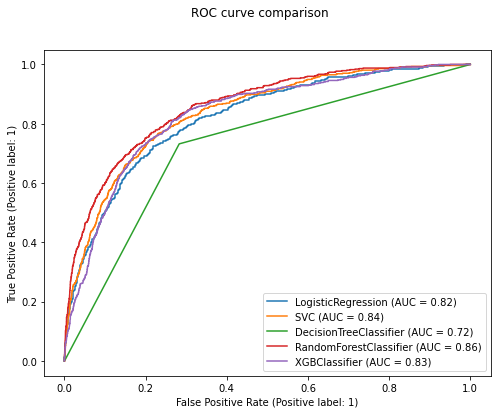

In [337]:
lr_disp = RocCurveDisplay.from_estimator(lr_cf_tuned, X_test, y_test_r)
svm_disp = RocCurveDisplay.from_estimator(svm_cf_tuned, X_test, y_test_r, ax=lr_disp.ax_)
dt_disp = RocCurveDisplay.from_estimator(dt_cf, X_test, y_test_r, ax=lr_disp.ax_)
rf_disp = RocCurveDisplay.from_estimator(rf_cf_tuned, X_test, y_test_r, ax=lr_disp.ax_)
xgb_disp = RocCurveDisplay.from_estimator(xgb_cf_tuned, X_test, y_test_r, ax=lr_disp.ax_)
lr_disp.figure_.suptitle("ROC curve comparison")
lr_disp.figure_.set_size_inches(8, 6)
plt.show()

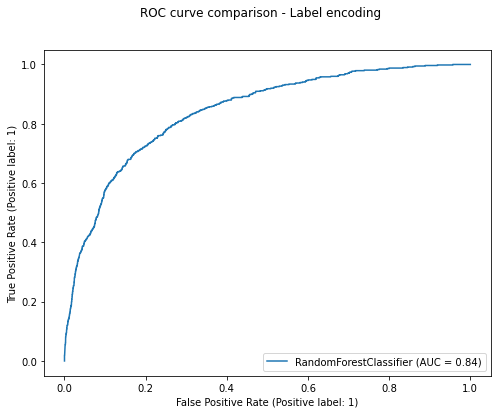

In [304]:
rf_lbl_disp = RocCurveDisplay.from_estimator(rf_cf_lbl, X_test_lbl, y_test_r)
rf_lbl_disp.figure_.suptitle("ROC curve comparison - Label encoding")
rf_lbl_disp.figure_.set_size_inches(8, 6)
plt.show()

Welche Features waren wichtig für die Entscheidungen des RandomForest?

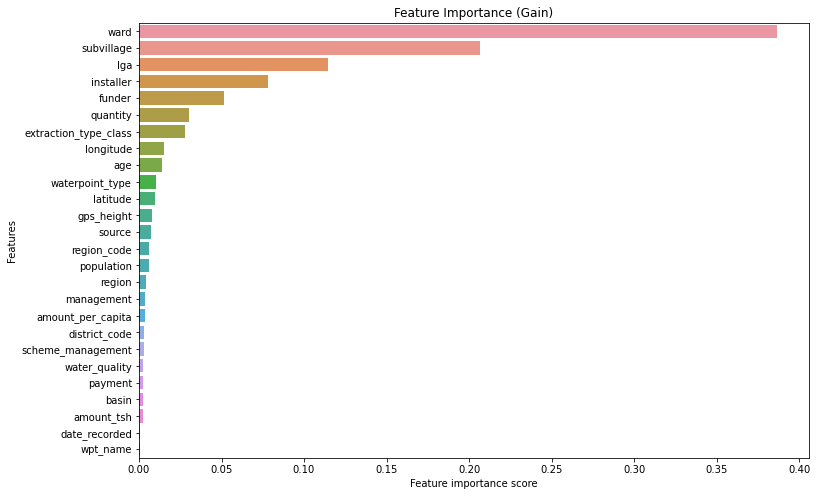

In [331]:
feature_names = ['funder', 'installer', 'subvillage', 'lga', 'ward', 'management', 'basin', 'payment','water_quality', 'quantity',
                    'source','waterpoint_type', 'extraction_type_class', 'region', 'region_code', 'district_code', 'wpt_name',
                    "amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude', "scheme_management",
                    "date_recorded", "age"]
feature_scores = pd.Series(rf_cf_lbl.feature_importances_, index=feature_names).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Feature Importance (Gain)")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

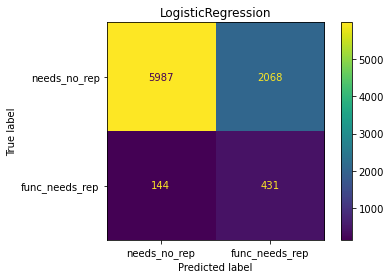

LogisticRegression: 
               precision    recall  f1-score   support

           0       0.98      0.74      0.84      8055
           1       0.17      0.75      0.28       575

    accuracy                           0.74      8630
   macro avg       0.57      0.75      0.56      8630
weighted avg       0.92      0.74      0.81      8630



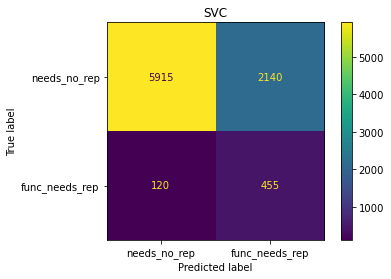

SVC: 
               precision    recall  f1-score   support

           0       0.98      0.73      0.84      8055
           1       0.18      0.79      0.29       575

    accuracy                           0.74      8630
   macro avg       0.58      0.76      0.56      8630
weighted avg       0.93      0.74      0.80      8630



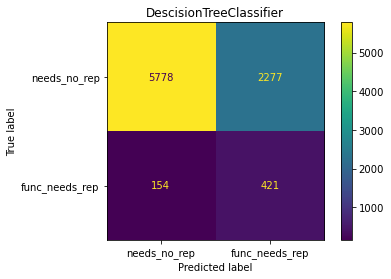

DescisionTreeClassifier: 
               precision    recall  f1-score   support

           0       0.97      0.72      0.83      8055
           1       0.16      0.73      0.26       575

    accuracy                           0.72      8630
   macro avg       0.57      0.72      0.54      8630
weighted avg       0.92      0.72      0.79      8630



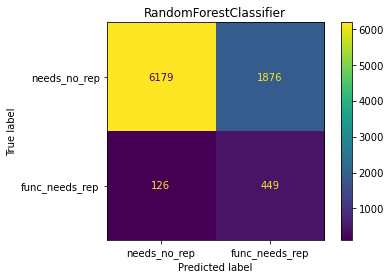

RandomForestClassifier: 
               precision    recall  f1-score   support

           0       0.98      0.77      0.86      8055
           1       0.19      0.78      0.31       575

    accuracy                           0.77      8630
   macro avg       0.59      0.77      0.59      8630
weighted avg       0.93      0.77      0.82      8630



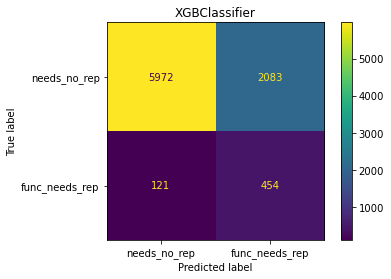

XGBClassifier: 
               precision    recall  f1-score   support

           0       0.98      0.74      0.84      8055
           1       0.18      0.79      0.29       575

    accuracy                           0.74      8630
   macro avg       0.58      0.77      0.57      8630
weighted avg       0.93      0.74      0.81      8630



In [348]:
predictions = lr_cf_tuned.predict(X_test)
cm = confusion_matrix(y_test_r, predictions, labels=lr_cf_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['needs_no_rep', 'func_needs_rep'])
disp.plot()
plt.title('LogisticRegression')
plt.show()
print('LogisticRegression: \n',classification_report(y_test_r, predictions))

predictions = svm_cf_tuned.predict(X_test)
cm = confusion_matrix(y_test_r, predictions, labels=svm_cf_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['needs_no_rep', 'func_needs_rep'])
disp.plot()
plt.title('SVC')
plt.show()
print('SVC: \n',classification_report(y_test_r, predictions))

predictions = dt_cf.predict(X_test)
cm = confusion_matrix(y_test_r, predictions, labels=dt_cf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['needs_no_rep', 'func_needs_rep'])
disp.plot()
plt.title('DescisionTreeClassifier')
plt.show()
print('DescisionTreeClassifier: \n',classification_report(y_test_r, predictions))

predictions = rf_cf_tuned.predict(X_test)
cm = confusion_matrix(y_test_r, predictions, labels=rf_cf_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['needs_no_rep', 'func_needs_rep'])
disp.plot()
plt.title('RandomForestClassifier')
plt.show()
print('RandomForestClassifier: \n',classification_report(y_test_r, predictions))

predictions = xgb_cf_tuned.predict(X_test)
cm = confusion_matrix(y_test_r, predictions, labels=xgb_cf_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['needs_no_rep', 'func_needs_rep'])
disp.plot()
plt.title('XGBClassifier')
plt.show()
print('XGBClassifier: \n',classification_report(y_test_r, predictions))

In [295]:
df_test['t_needs_rep'].value_counts(normalize=True)

0    0.933372
1    0.066628
Name: t_needs_rep, dtype: float64

Die AUC ergibt einen guten Wert, aber klassifiziert das Modell wie es soll? Muss eher Recall oder Precision priorisiert werden?

-> aktuell wird ein relativ großer Anteil der wartungsbedürftigen Brunnen nicht erkannt, gleichzeitig werden aber trotzdem viele andere Brunnen für Wartung vorgemerkt.

Nachfolgende Grafik visualisiert den Precision-Recall Trade-off.

Text(0.5, 1.0, '2-class Precision-Recall curve')

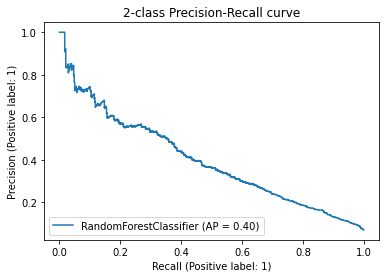

In [287]:
display = PrecisionRecallDisplay.from_estimator(
    rf_cf_tuned, X_test, y_test_r
)
display.ax_.set_title("2-class Precision-Recall curve")